In [1]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from scipy.sparse.linalg import eigs 
import scipy.linalg as lin
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import scipy.sparse as sp
from scipy.sparse import csr_matrix, coo_matrix
from zipfile import ZipFile
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
############################################
#Loading the Matrix A as Sparse Matrix 
A = sp.load_npz('speech_graph_sparse.npz')
A = A.toarray()
############################################
#Building Matirx D
m = np.shape(A)[0]

D = np.zeros((m,m))
for i in range(m):
    D[i,i] = np.sum(A[:,i])

# Compute Unnormalized Laplacian Matrix L
L = D - A
I = np.identity(m);


# Compute Normalized Laplacian Lt 
Dh = lin.sqrtm(D)
Dh = lin.inv(Dh)
Lt = I - Dh.dot(A.dot(Dh))

#Calculate the Eigen Values
E, V = eigs(Lt,201,which='SR')
E = np.real(E)
V = np.real(V)



#print(Y)

In [3]:
Y1 = V[:,1:31]
Y2 = V[:,1:41]
Y3 = V[:,1:51]
Y4 = V[:,1:61]
Y5 = V[:,1:71]

In [4]:
#Vaulizing the Clusters 
scatter = go.Scatter3d(
    x = Y2[:,0],
    y = Y2[:,1],
    z = Y2[:,2],
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=0.8))

data = [scatter]
iplot(data, filename='fig0')

In [5]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics
np.random.seed(0)
sc = SpectralClustering(4, affinity='precomputed', n_init=100)
sc.fit(A)
labels = sc.labels_
YY = sc.fit_predict(A)

#Define the length of the total number of the speech
speeches = np.arange(2740)

#Get the Assignments of the Speech in Different Clusters
speech_1        = []
speech_2        = []
speech_3        = []
speech_4        = []

#Making Tables for Four Clusters
for i in range(len(speeches)):
    if labels[i] == 0:
        speech_1.append(i)
    if labels[i] == 1:
        speech_2.append(i)
    if labels[i] == 2:
        speech_3.append(i)
    if labels[i] == 3:
        speech_4.append(i)

In [6]:
############################################
#Loading the Vector Matrix as Sparse Matrix 
Vec = sp.load_npz('csr_vectors.npz')
Vec = Vec.toarray()
print(np.shape(Vec))
############################################

(2740, 50000)


In [7]:
from sklearn.random_projection import SparseRandomProjection
transformer     = SparseRandomProjection(n_components=1100)
vectors_reduced = transformer.fit_transform(Vec[:, :25000])
print(np.shape(vectors_reduced))

(2740, 1100)


In [8]:
#use PCA to reduce the demension of the speech_vector matrix
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2740)
# V_pca = pca.fit_transform(Vec)
# print(np.shape(Vec))
# from sklearn.decomposition import KernelPCA
# pca = KernelPCA(n_components=5000, kernel='rbf')
# V_pca = pca.fit_transform(Vec)
# print(V_pca[0,:])
# from sklearn.manifold import SpectralEmbedding
# embedder = SpectralEmbedding(n_components=1000, random_state=0, affinity='precomputed', eigen_solver="arpack")
# vectors_reduced = embedder.fit_transform(V_pca)

# from sklearn.cluster import SpectralClustering
# from sklearn import metrics
# np.random.seed(0)
# sc = SpectralClustering(500, affinity='precomputed', n_init=100)
# vectors_reduced = sc.fit(vectors_reduced)

In [9]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=3)
cca.fit(Y2, vectors_reduced)
X_c, Y_c = cca.transform(Y2, vectors_reduced)

In [10]:
a1 = []
a2 = []
a3 = []
a13 = []
a18 = []
a24 = []
a27 = []
a177= []
for i in range(len(speeches)):
    if i == 0:
        a1.append(X_c[i,:])
    if i == 1:
        a2.append(X_c[i,:])
    if i == 2:
        a3.append(X_c[i,:])
    if i == 12:
        a13.append(X_c[i,:])
    if i == 17:
        a18.append(X_c[i,:])
    if i == 23:
        a24.append(X_c[i,:])
    if i == 27:
        a27.append(X_c[i,:])
    if i == 176:
        a177.append(X_c[i,:])

b1 = np.vstack((a1, a3))
b2 = np.vstack((a27, a177))
b3 = np.vstack((a2, a13))
b4 = np.vstack((a18, a24)) 
against_speech = np.vstack((b1, b2))
for_speech     = np.vstack((b3, b4)) 

#print(X_c[0,:], X_c[1,:], X_c[2,:], X_c[12,:],X_c[17,:], X_c[23,:],X_c[27,:], X_c[176,:])
#print(against_speech, for_speech)

In [11]:
#Vaulizing the Clusters in CCA
scatter_1 = go.Scatter3d(
    x = X_c[:,0], 
    y = X_c[:,1],
    z = X_c[:,2],
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=1))

scatter_2 = go.Scatter3d(
    x = against_speech[:,0], 
    y = against_speech[:,1],
    z = against_speech[:,2],
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='red',
        opacity=1))

scatter_3 = go.Scatter3d(
    x = for_speech[:,0], 
    y = for_speech[:,1],
    z = for_speech[:,2],
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='yellow',
        opacity=1))

data = [scatter_1, scatter_2,scatter_3]
iplot(data, filename='fig0')

In [12]:
# from sklearn.manifold import TSNE
# def tsne(X,perplex,rate):
    
#     X_embedded = TSNE(n_components=2,perplexity=perplex, learning_rate=rate).fit_transform(X)
#     return X_embedded

# speech_tsne = tsne(X_c3,25,200)
# print(np.shape(speech_tsne))

In [13]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2,n_neighbors=5)
speech_isomap = embedding.fit_transform(X_c)
print(np.shape(speech_isomap))

(2740, 2)


In [19]:
#Assign four groups based on results came out from CCA via assignments came out from spectral embedding to the graph_table
#Also, pick up the first two dimensions from each group for visualization in K-Means 
speech_cca_1        = []
speech_cca_2        = []
speech_cca_3        = []
speech_cca_4        = []

a1 = []
b1 = []
c1 = []
sc1 = []

a2 = []
b2 = []
c2 = []
sc2 = []

a3 = []
b3 = []
c3 = []
sc3 = []

a4 = []
b4 = []
c4 = []
sc4 = []

for i in speech_1:
    speech_cca_1.append(X_c[i,:]) 
for i in range(len(speech_cca_1)):
    a1.append(speech_cca_1[i][0])
    b1.append(speech_cca_1[i][1])
    c1.append(speech_cca_1[i][2])
    sc1 = np.array([a1,b1]).T
print(np.shape(sc1))



for i in speech_2:
    speech_cca_2.append(X_c[i,:])
for i in range(len(speech_cca_2)):
    a2.append(speech_cca_2[i][0])
    b2.append(speech_cca_2[i][1])
    c2.append(speech_cca_2[i][2])
    sc2 = np.array([a2,b2]).T
print(np.shape(sc2))

for i in speech_3:
    speech_cca_3.append(X_c[i,:])
for i in range(len(speech_cca_3)):
    a3.append(speech_cca_3[i][0])
    b3.append(speech_cca_3[i][1])
    c3.append(speech_cca_3[i][2])
    sc3 = np.array([a3,b3]).T
print(np.shape(sc3))

for i in speech_4:
    speech_cca_4.append(X_c[i,:])
for i in range(len(speech_cca_4)):
    a4.append(speech_cca_4[i][0])
    b4.append(speech_cca_4[i][1])
    c4.append(speech_cca_4[i][2])
    sc4 = np.array([a4,b4]).T
print(np.shape(sc4))

##############################################Reshape the results to arrays################################################
np.array(speech_cca_1).reshape(1830,2)
np.array(speech_cca_2).reshape(329,2)
np.array(speech_cca_3).reshape(285,2)
np.array(speech_cca_4).reshape(296,2)

#Use 3D plots to check if the the labels from the spectral embedding actually worked
scatter_1 = go.Scatter3d(
    x = a1, 
    y = b1,
    z = c1,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='red',
        opacity=1))

# data = [scatter_1]
# iplot(data, filename='fig0')

scatter_2 = go.Scatter3d(
    x = a2, 
    y = b2,
    z = c2,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=1))

scatter_3 = go.Scatter3d(
    x = a3, 
    y = b3,
    z = c3,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='green',
        opacity=1))

scatter_4 = go.Scatter3d(
    x = a4, 
    y = b4,
    z = c4,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='black',
        opacity=1))


data = [scatter_1,scatter_2, scatter_3, scatter_4]
iplot(data, filename='fig0')


(296, 2)
(1830, 2)
(285, 2)
(329, 2)


ValueError: cannot reshape array of size 888 into shape (1830,2)

In [ ]:
y1 = []
y2 = []
y3 = []
y4 = []

for i in range(1830):
    y1.append(0)
for i in range(329):
    y2.append(0)    
for i in range(285):
    y3.append(0)
for i in range(296):
    y4.append(0)

print(np.shape(y4), np.shape(a4))
scatter_1 = go.Scatter(
    x = a1, 
    y = y1,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='red',
        opacity=1))

scatter_2 = go.Scatter(
    x = a2, 
    y = y2,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=1))

scatter_3 = go.Scatter(
    x = a3,
    y = y3,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='green',
        opacity=1))

scatter_4 = go.Scatter(
    x = a4, 
    y = y4,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='black',
        opacity=1))



data = [scatter_1,scatter_2, scatter_3, scatter_4]
iplot(data, filename='fig0')

In [ ]:
scatter_1 = go.Scatter(
    x = a1, 
    y = b1,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='red',
        opacity=1))

scatter_2 = go.Scatter(
    x = a2, 
    y = b2,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=1))

scatter_3 = go.Scatter(
    x = a3, 
    y = b3,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='green',
        opacity=1))

scatter_4 = go.Scatter(
    x = a4, 
    y = b4,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='black',
        opacity=1))



data = [scatter_1,scatter_2, scatter_3, scatter_4]
iplot(data, filename='fig0')

In [ ]:
#Use 3D plots to check if the the labels from the spectral embedding actually worked
scatter_1 = go.Scatter3d(
    x = a1, 
    y = b1,
    z = c1,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='red',
        opacity=1))

# data = [scatter_1]
# iplot(data, filename='fig0')

scatter_2 = go.Scatter3d(
    x = a2, 
    y = b2,
    z = c2,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='blue',
        opacity=1))

scatter_3 = go.Scatter3d(
    x = a3, 
    y = b3,
    z = c3,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='green',
        opacity=1))

scatter_4 = go.Scatter3d(
    x = a4, 
    y = b4,
    z = c4,
    mode = 'markers',
    marker=dict(
        size=5,
        symbol='circle',
        color='black',
        opacity=1))


data = [scatter_1,scatter_2, scatter_3, scatter_4]
iplot(data, filename='fig0')

In [15]:
from sklearn.manifold import TSNE
def tsne(X,perplex,rate):
    
    X_embedded = TSNE(n_components=2,perplexity=perplex, learning_rate=rate).fit_transform(X)
    return X_embedded

speech_cca_1 = tsne(speech_cca_1,25,200)
speech_cca_2 = tsne(speech_cca_2,25,200)
speech_cca_3 = tsne(speech_cca_3,25,200)
speech_cca_4 = tsne(speech_cca_4,25,200)

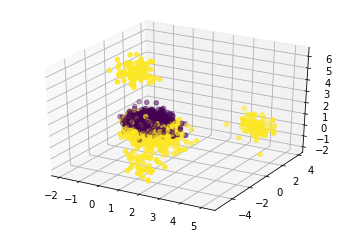

In [16]:
#Use K-means to separate the 'for' and 'agasint' groups in each speech_vector_# group
from sklearn.cluster import KMeans
#K_means to classify the 'for' and 'agasint' groups in speech_vector_1
model_1 = KMeans(n_clusters = 2)#, init='k-means++')
model_1.fit(speech_cca_1)
lables_1 = model_1.predict(speech_cca_1)
#K_means to classify the 'for' and 'agasint' groups in speech_vector_2
model_2 = KMeans(n_clusters = 2)#, init='k-means++')
model_2.fit(speech_cca_2)
lables_2 = model_2.predict(speech_cca_2)
#K_means to classify the 'for' and 'agasint' groups in speech_vector_3
model_3 = KMeans(n_clusters = 2)#, init='k-means++')
model_3.fit(speech_cca_3)
lables_3 = model_3.predict(speech_cca_3)
#K_means to classify the 'for' and 'agasint' groups in speech_vector_4
model_4 = KMeans(n_clusters = 2)#, init='k-means++')
model_4.fit(speech_cca_4)
lables_4 = model_4.predict(speech_cca_4)
#print(np.shape(lables_1), np.shape(lables_2),lables_4, np.shape(lables_4))
# plt.scatter(a1, b1, c=lables_1, s=50, cmap='viridis')
# plt.scatter(sc2[:, 0], sc2[:, 1], c=lables_2, s=50, cmap='viridis')
# plt.scatter(sc3[:, 0], sc3[:, 1], c=lables_3, s=50, cmap='viridis')
# plt.scatter(sc4[:, 0], sc4[:, 1], c=lables_4, s=50, cmap='viridis')


#Use a 3D plot to check the "for" and "agaisnt" labels
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = a1
xdata = b1
ydata = c1
ax.scatter3D(xdata, ydata, zdata, c=lables_1, cmap='viridis');

zdata = a2
xdata = b2
ydata = c2
ax.scatter3D(xdata, ydata, zdata, c=lables_2, cmap='viridis');

zdata = a3
xdata = b3
ydata = c3
ax.scatter3D(xdata, ydata, zdata, c=lables_3, cmap='viridis');

zdata = a4
xdata = b4
ydata = c4
ax.scatter3D(xdata, ydata, zdata, c=lables_4, cmap='viridis');


# plt.scatter(sc1[:, 0], sc1[:, 1], c=lables_1, s=50, cmap='viridis')
# plt.scatter(sc2[:, 0], sc2[:, 1], c=lables_2, s=50, cmap='viridis')
# plt.scatter(sc3[:, 0], sc3[:, 1], c=lables_3, s=50, cmap='viridis')
# plt.scatter(sc4[:, 0], sc4[:, 1], c=lables_4, s=50, cmap='viridis')
# from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2).fit_transform(speech_cca_1)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [17]:
#Build the matrix for the speech with repect to their "for" or "agaisnt" labels from the speech_vector_table
speech_labels_1 = []
speech_labels_2 = []
speech_labels_3 = []
speech_labels_4 = []
for i in range(len(speech_1)):
    speech_labels_1.append([speech_1[i], lables_1[i]])
for i in range(len(speech_2)):
    speech_labels_2.append([speech_2[i], lables_2[i]])
for i in range(len(speech_3)):
    speech_labels_3.append([speech_3[i], lables_3[i]])
for i in range(len(speech_4)):
    speech_labels_4.append([speech_4[i], lables_4[i]])
#print(speech_labels_4)

#reverse the labels in case they were labeled wrong in the clusters
speech_labels_new_1 = []
for i in range(len(speech_labels_1)):
    if speech_labels_1[i][1] == 0:
        speech_labels_new_1.append([speech_labels_1[i][0],1])
    if speech_labels_1[i][1] == 1:
        speech_labels_new_1.append([speech_labels_1[i][0],0])   

speech_labels_new_2 = []
for i in range(len(speech_labels_2)):
    if speech_labels_2[i][1] == 0:
        speech_labels_new_2.append([speech_labels_2[i][0],1])
    if speech_labels_2[i][1] == 1:
        speech_labels_new_2.append([speech_labels_2[i][0],0])  
        
speech_labels_new_3 = []
for i in range(len(speech_labels_3)):
    if speech_labels_3[i][1] == 0:
        speech_labels_new_3.append([speech_labels_3[i][0],1])
    if speech_labels_3[i][1] == 1:
        speech_labels_new_3.append([speech_labels_3[i][0],0])   
        
speech_labels_new_4 = []
for i in range(len(speech_labels_4)):
    if speech_labels_4[i][1] == 0:
        speech_labels_new_4.append([speech_labels_4[i][0],1])
    if speech_labels_4[i][1] == 1:
        speech_labels_new_4.append([speech_labels_4[i][0],0])  
#print(speech_labels_new_4) 

speech_labels_a = []
speech_labels_b = []
speech_labels   = []
speech_labels_a = np.vstack((speech_labels_1, speech_labels_2))
speech_labels_b = np.vstack((speech_labels_new_3, speech_labels_4))
speech_labels   = np.vstack((speech_labels_a, speech_labels_b))
a = pd.DataFrame(speech_labels, columns = ['column_fun_1', 'column_fun_2'])
final = []
final = a.sort_values(by='column_fun_1')
final_a = np.array(final).reshape(2740,2)

 

num=0
for each in final_a:
    if num == 1 or num == 3 or num == 27 or num == 177:
        print("against should be 1, is: " + str(each[1]))
    if num == 2 or num == 13 or num == 18 or num == 24:
        print("for should be 0, is: " + str(each[1]))
    num = num+1

against should be 1, is: 1
for should be 0, is: 0
against should be 1, is: 1
for should be 0, is: 0
for should be 0, is: 0
for should be 0, is: 0
against should be 1, is: 1
against should be 1, is: 1


In [22]:
prediction = final_a
np.save('result.npy', prediction)